In [3]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

## units of the simulation 
- $L = \sqrt{D/k_{ab}^0}$
- $T = 1/k_{ab}^0$
- $E = 1/\beta$
## parameters of the simulation 
- $k_{bc}^0 = 1$ : equal to $k_{ab}^0$
- $k_{ac}^0 = 1$ : equal to $k_{ab}^0$
- $\epsilon_{ac}$ = 0.1
- $V$ = 1.

In [10]:
kbc = 1.
kac = 1.
Eac = 0.1
V0 = 1.

X0 = -1 # left most boundary condition
Xf = 1 # right most boundary at which we will perform the numerical resolution
n = 100 # number of point use for space
dx = (Xf-X0)/n # size of the step

## Equation differential of the problem :
$$ 
\begin{cases}
& \partial_t \rho_a = \partial_x^2 \rho_a +\partial_x\rho_a \partial_x V + \rho_a \partial_x^2 V + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b =  \partial_x^2 \rho_b +k_{ab} \rho_a + k_{cb} \rho_c - \rho_b(k_{bc}+k_{ba})\\
& \partial_t \rho_c = \partial_x^2 \rho_c +k_{ac} \rho_a + k_{bc} \rho_b - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = e^V \hspace{1cm} k_{bc} = k_{bc}^0 \hspace{1cm} k_{ac} = k_{ac}^0e^V\\
&k_{ba} = 1 \hspace{1cm} k_{cb} = k_{bc}^0 \hspace{1cm} k_{ca} = k_{ac}^0 e^{-\epsilon_{ac}}
\end{cases}
$$
We define $\bar{\rho} = \{\rho_i(x+dx), \rho_i(x), \rho_i(x-dx)\}_i$, with $i = a,b,c$


And the associate matrix :
$$
P = 
\begin{bmatrix}
-\partial_xV & -\partial_x^2V+k_{ac}^0e^V+e^V & 0 & -1 & 0 & -k_{ac}^0 e^{-\epsilon_{ac}} \\
1 & 0 & 0 & 0 & 0 & 0 \\
0 & -e^V & 0 & k_{bc}^0+1 & 0 & -k_{bc}^0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & -k_{ac}^0 e^V & 0 & -k_{bc}^0  &0 & k_{ac}^0 e^{-\epsilon_{ac}}+k_{bc}^0\\
0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$$
So that we get : 
$$
\bar{\rho}(t+dt)(x) = P \bar{\rho} + \rho(t)
$$

$$
\begin{pmatrix}
\rho_a(x+dx) & \rho_a(x)& \rho_a(x-dx)& \rho_b(x+dx)& \rho_b(x)&\rho_b(x-dx)& \rho_c(x+dx)& \rho_c(x)&\rho_c(x-dx)\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1/h^2 + \partial_x V/(2*h) & -2/h^2 +\partial_x^2V-k_{ac}^0e^V-e^V & 1/h^2-\partial_x V/(2*h) & 0 & 1 & 0 & 0 & k_{ac}^0 e^{-\epsilon_{ac}} & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & e^V & 0 & 1/h^2 & - (k_{bc}^0 + 1) -2/h^2 & 1/h^2 & 0 & k_{bc}^0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & k_{ac}^0 e^V & 0 & 0 & k_{bc}^0 & 0 & 1/h^2 & -2/h^2 - k_{ac}^0 e^{-\epsilon_{ac}}-k_{bc}^0 & 1/h^2\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix}
$$

In [26]:
def P(V,dV,ddV,x):
    return np.array([[0,0,0,0,0,0,0,0,0],
                    [1/h**2+dV(x)/(2*h), -2/h**2+ddV(x) - (kac+1)*np.exp(V(x)),1/h**2 - dV(x) / (2*h),0,1,0,0,+kac*np.exp(-Eac),0],
                    [0,0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0],
                    [0,np.exp(V(x)),0,1/h**2,-kbc-1-2/h**2, 1/h**2,0,kbc,0],
                    [0,0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0,0],
                    [0,kac*np.exp(V(x)),0,0,kbc,0,1/h**2,-kac*np.exp(-Eac)-kbc-2/h**2,1/h**2],
                    [0,0,0,0,0,0,0,0,0]
                    ])
def PA(V,dV,ddV):
    matrix = np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            if i == j :
                matrix[i,j] = -2/dx**2+ddV(i*dx) - (kac+1)*np.exp(V(i*dx))
            if i==j+1:
                matrix[i,j] = 1/dx**2+dV(i*dx)/(2*dx)
            if i==j-1:
                matrix[i,j] = 1/dx**2 - dV(i*dx) / (2*dx)
    return matrix
def PB(V,dV,ddV) : 
    matrix = np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            if i==j:
                matrix[i,j] = -kbc-1-2/dx**2
            if i==j+1 or i==j-1:
                matrix[i,j] = 1/dx**2
    return matrix
def PC(V,dV,ddV):
    matrix = np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            if i==j:
                matrix[i,j] = -kac*np.exp(-Eac)-kbc-2/dx**2
            if i==j+1 or i==j-1:
                matrix[i,j] = 1/dx**2   
    return matrix


def V(x) :
    if x<0:
        return 0.
    else :
        return V0
dV = lambda x : 0
ddV = lambda x : 0
# We write the function f that takes two arguments : X (the position in space) and Y
# the value of the vector rho at X. The function simply returns the derivative of the
# vector rho at X

print("step size : "+str(h))
def evolv(rho_a,rho_b,rho_c,dt):
    # return rho(t+dt)
    # rho is a 2d array of shape 3:n
    #for i in range(rho.shape[0]):
    #    rho_int = np.array([rho[0][i+1],rho[0][i],rho[0][i-1],rho[1][i+1],rho[1][i],rho[1][i-1],rho[2][i+1],rho[2][i],rho[2][i-1]])
    #    rho_int+= np.dot(P(V,dV,ddV,i*dx),rho_int)*dx
    #    rho[:,i] = np.array([rho_int[1], rho_int[4], rho_int[7]])
    rho_a += (np.dot(PA(V,dV,ddV,),rho_a) + rho_b + +kac*np.exp(-Eac)*rho_c) * dt
    rho_b += (np.dot(PB(V,dV,ddV),rho_b) + np.array([np.exp(V(i*dx)) * rho_a[i] for i in range(n)]) + kbc*rho_c) * dt
    rho_c += (np.dot(PC(V,dV,ddV),rho_c) + np.array([kac*np.exp(V(i*dx)) * rho_a[i] for i in range(n)]) + kbc*rho_b) *dt
    return rho_a,rho_b,rho_c

step size : 0.0002


In [27]:
ra_no_norm = kac * np.exp(-Eac) * 1 + kbc*1 + kbc*kac*np.exp(-Eac)
rb_no_norm = kac*np.exp(-Eac)*np.exp(0)+np.exp(0)*kbc+kac*np.exp(0)*kbc
rc_no_norm = kac*np.exp(0)*kbc+1*kac*np.exp(0)+np.exp(0)*kbc
S = ra_no_norm+rb_no_norm+rc_no_norm
ra_infty = ra_no_norm/S
rb_infty = rb_no_norm/S
rc_infty = rc_no_norm/S

rho_0 = np.array([0,ra_infty,0,rb_infty,0,rc_infty])

In [28]:
ra_inf_nonorm = kac * np.exp(-Eac) * 1 + kbc*1 + kbc*kac*np.exp(-Eac)
rb_inf_nonorm = kac*np.exp(-Eac)*np.exp(V0)+np.exp(V0)*kbc+kac*np.exp(V0)*kbc
rc_inf_nonorm = kac*np.exp(V0)*kbc+1*kac*np.exp(V0)+np.exp(V0)*kbc
S = ra_inf_nonorm+rb_inf_nonorm+rc_inf_nonorm
rainfty = ra_inf_nonorm/S
rbinfty = rb_inf_nonorm/S
rcinfty = rc_inf_nonorm/S

rho_inf = np.array([0,rainfty,0,rbinfty,0,rcinfty])

## Perform the numerical solution

In [70]:
rho_a_0 = np.array([ra_infty for _ in range(n)])
rho_b_0 = np.array([rb_infty for _ in range(n)])
rho_c_0 = np.array([rc_infty for _ in range(n)])

In [81]:
for t in range(100000):
    rho_a,rho_b,rho_c = evolv(rho_a_0,rho_b_0,rho_c_0,0.0001)

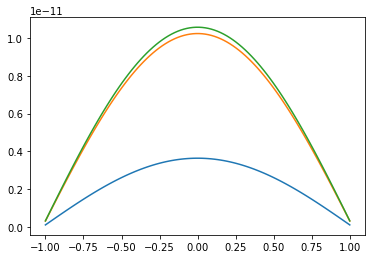

In [83]:
plt.plot(np.linspace(X0,Xf,n),rho_a)
plt.plot(np.linspace(X0,Xf,n),rho_b)
plt.plot(np.linspace(X0,Xf,n),rho_c)

In [76]:
rho_a

array([0.20134219, 0.30204096, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219179,
       0.32219179, 0.32219179, 0.32219179, 0.32219179, 0.32219

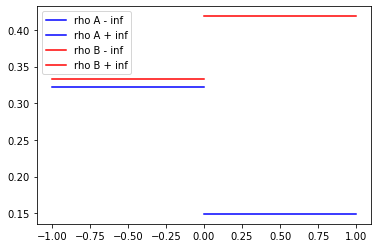

In [11]:
plt.plot(np.linspace(X0,0,n//2),[rho_0[1] for _ in range(n//2)],label='rho A - inf',c='blue')
plt.plot(np.linspace(0,Xf,n//2),[rho_inf[1] for _ in range(n//2)],label='rho A + inf',c='blue')
plt.plot(np.linspace(X0,0,n//2),[rho_0[3] for _ in range(n//2)],label='rho B - inf',c='red')
plt.plot(np.linspace(0,Xf,n//2),[rho_inf[3] for _ in range(n//2)],label='rho B + inf',c='red')
plt.legend()

In [24]:
Mat = P(V,dV,ddV,1)
la.eigvals(Mat)

array([ 2.52777393e+00, -2.52777393e+00, -3.40899739e-08,  3.40899746e-08,
       -1.71806870e+00,  1.71806870e+00])